In [12]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from edo import EDOModel

Vamos supor que você queira fazer um modelo que rankeia os tickets de suporte dos consumidores por prioridade e direciona-os para o departamento correto.O seu modelo possui três entradas:


* o titulo do ticket (text input)
* o texto do ticket (text input)
* qualquer rótulo adicionado pelo consumidor (categorical input, assumido aqui como um one-hot encoded)

Nós podemos codificar as entradas de texto como arrays de um e zeros de tamanhos de vocabulário

seu modelo também tem duas saídas:

* o score de prioridade do ticket, um escalar entre 0 e 1 (sigmoid output)
* o departamento que tem que receber (softmax sobre o conjunto de departamento)

construindo usando functional API

In [13]:
vocabulary_size = 10000
num_tags = 100
num_departments = 4

title = keras.Input(shape=(vocabulary_size,),name='title') # define a entrada do modelo
text_body = keras.Input(shape=(vocabulary_size,),name='text_body') #define a entrada do modelo
tags = keras.Input(shape=(num_tags,),name='tags') # define a entrada do modelo

features = keras.layers.Concatenate()([title,text_body,tags]) # combina as features de entrada em um unico tensor concatenando-os
features = keras.layers.Dense(64,activation='relu')(features) # aplica uma camada intermediaria para recombina as entradas de features para uma representação mais rica

priority = keras.layers.Dense(1,activation='sigmoid',name='priority')(features) # saida do modelo

department = keras.layers.Dense(num_departments,activation='softmax',name='department')(features) # saida do modelo

model = keras.Model(inputs=[title,text_body,tags],outputs=[priority,department]) # cria o modelo

In [14]:
# dummy input variables
num_samples = 1280
title_data = np.random.randint(0,2,size=(num_samples,vocabulary_size))
text_body_data = np.random.randint(0,2,size=(num_samples,vocabulary_size))
tags_data = np.random.randint(0,2,size=(num_samples,num_tags))

#dummy outputs variables

priority_data = np.random.random(size=(num_samples,1))
department_data = np.random.random(size=(num_samples,num_departments))

model.compile(loss=['mse','categorical_crossentropy'], optimizer='adam',metrics=[['mse'],['accuracy']])

model.fit([title_data,text_body_data,tags_data],[priority_data,department_data],epochs=1)

model.evaluate([title_data,text_body_data,tags_data],[priority_data,department_data])

priority_preds,department_preds = model.predict([title_data,text_body_data,tags_data])

2024-12-27 17:43:22.480467: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 102400000 exceeds 10% of free system memory.
2024-12-27 17:43:22.604435: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 102400000 exceeds 10% of free system memory.


40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - department_accuracy: 0.2636 - loss: 15.1028 - priority_mse: 0.2949


2024-12-27 17:43:24.694274: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 102400000 exceeds 10% of free system memory.
2024-12-27 17:43:24.810405: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 102400000 exceeds 10% of free system memory.


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - department_accuracy: 0.2757 - loss: 13.8949 - priority_mse: 0.3382


2024-12-27 17:43:25.335215: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 102400000 exceeds 10% of free system memory.


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


uma outra maneira de compilar usando dicionarios que é bem melhor

In [15]:
model.compile(optimizer='adam',loss={'priority':'mse','department':'categorical_crossentropy'},metrics={'priority':'mse','department':'accuracy'})
model.fit({'title':title_data,'text_body': text_body_data,'tags':tags_data},{'priority':priority_data,'department':department_data})
priority_preds,department_preds = model.predict({'title':title_data,'text_body':text_body_data,'tags':tags_data})

40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - department_accuracy: 0.2610 - loss: 13.2088 - priority_mse: 0.3383
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


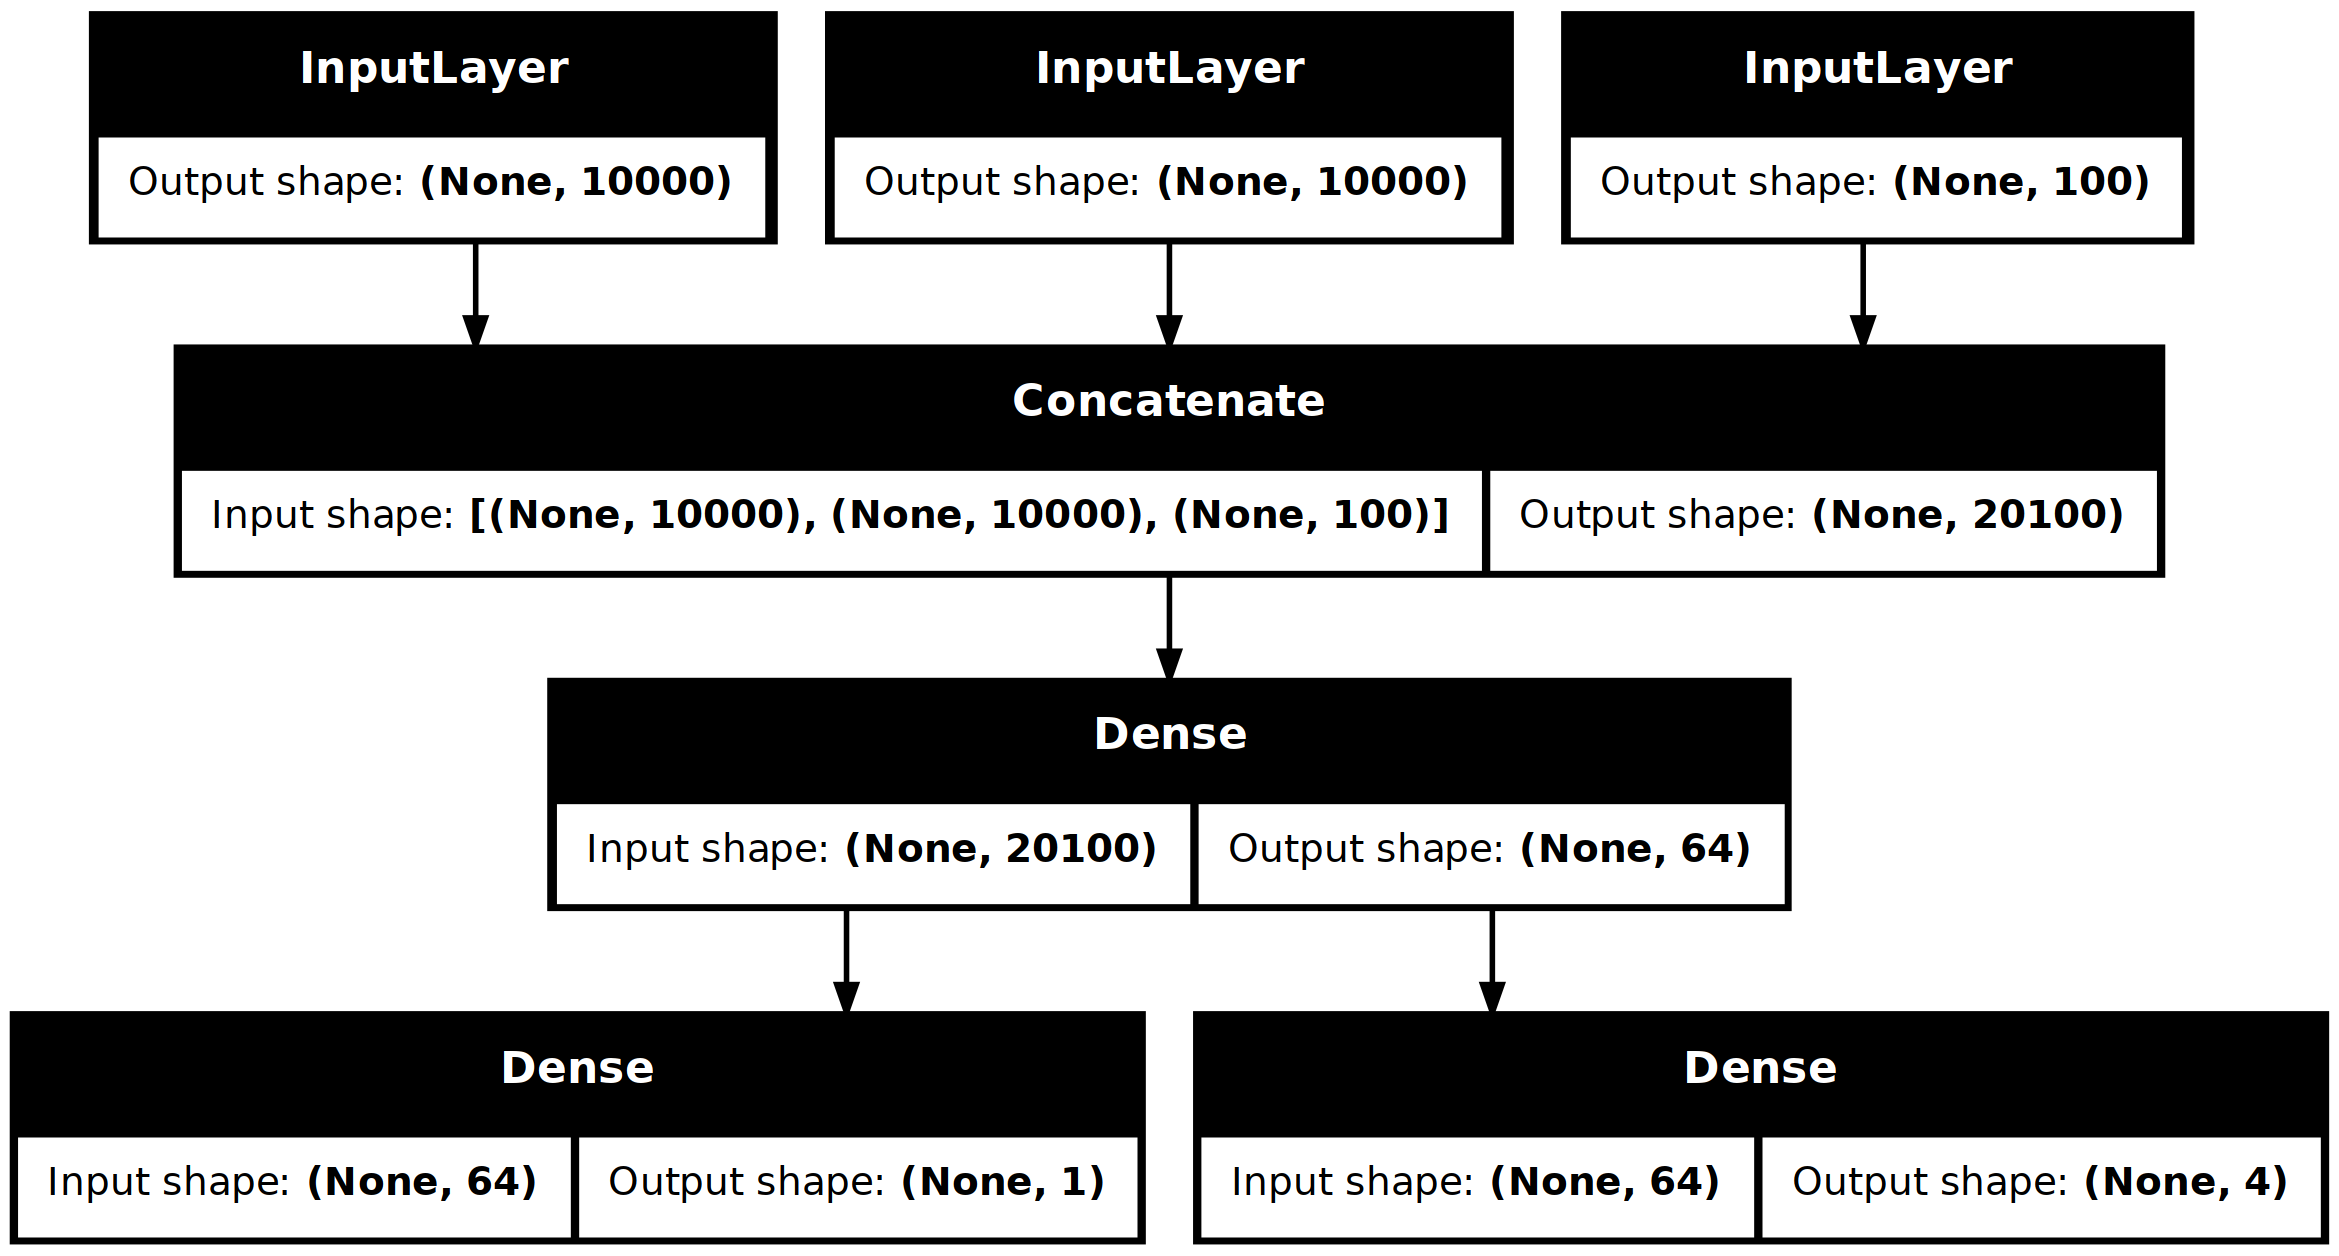

In [16]:
keras.utils.plot_model(model,show_shapes=True)

# extração de feature com modelo funcional

Vamos supor que você queira adicionar uma nova saída, mas não quer ter que criar um modelo do zero e treinar de novo. Você pode recomeçar pelas camadas intermediarias

In [17]:
features = model.layers[4].output
difficulty = keras.layers.Dense(3,activation='softmax',name='difficulty')(features)

new_model = keras.Model(
    inputs=[title,text_body,tags],
    outputs=[priority,department,difficulty]
)

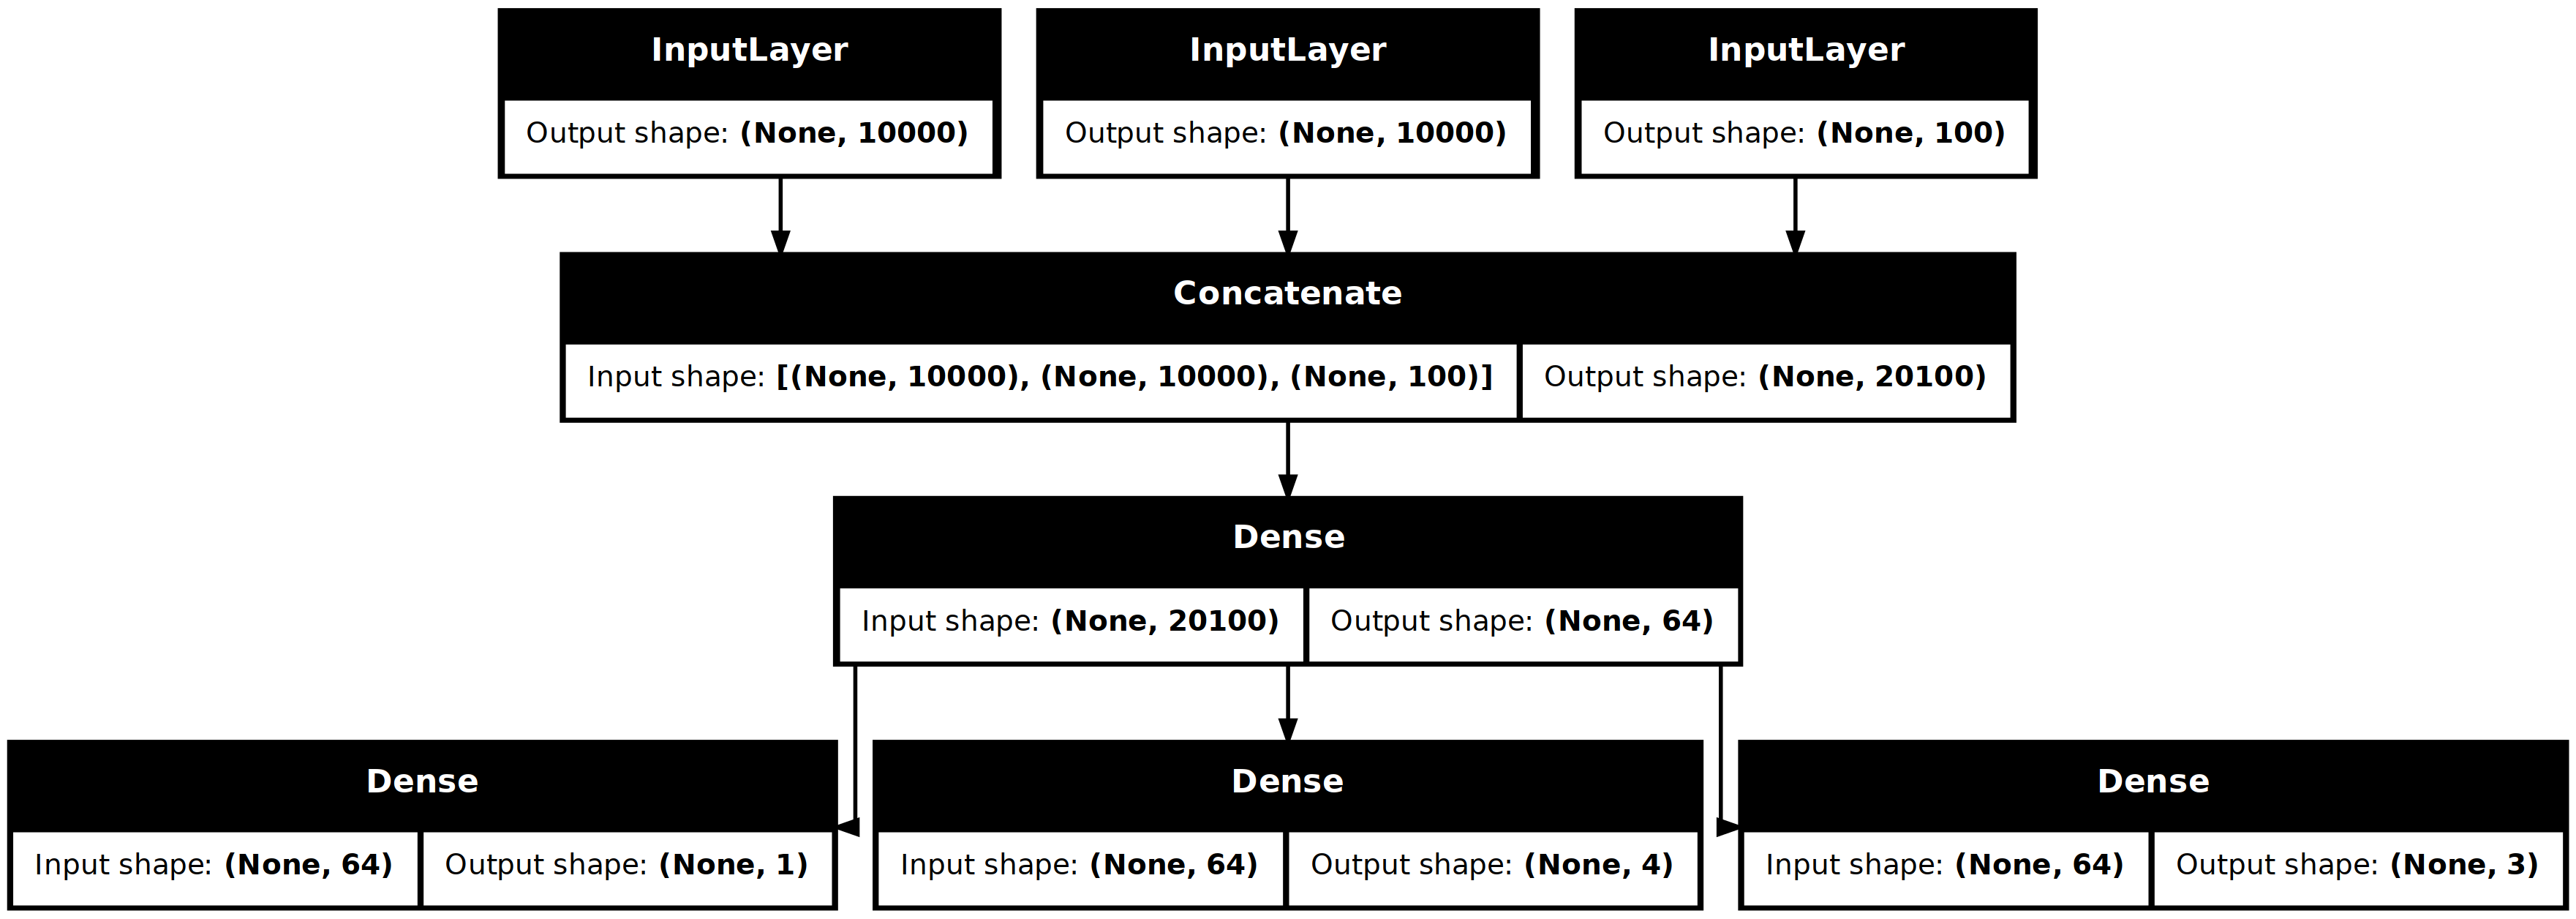

In [18]:
keras.utils.plot_model(new_model,show_shapes=True)

# Reescrevendo o problema como um subclassing model

In [19]:
class CustomerTicketModel(keras.Model):
    def __init__(self,num_departments):
        super().__init__()
        self.concat_layer = keras.layers.Concatenate()
        self.mixing_layer = keras.layers.Dense(64,activation='relu')
        self.priority_scorer = keras.layers.Dense(1,activation='sigmoid')
        self.department_classifier = keras.layers.Dense(num_departments,activation='softmax')

    def call(self,inputs): #forward pass
        title = inputs['title']
        text_body = inputs['text_body']
        tags = inputs['tags']

        features = self.concat_layer([title,text_body,tags])
        features = self.mixing_layer(features)
        priority = self.priority_scorer(features)
        department = self.department_classifier(features)
        return priority, department

In [20]:
model = CustomerTicketModel(4)

priority,department = model({'title':title_data,'text_body': text_body_data,'tags':tags_data})

In [21]:
model.compile(optimizer='adam',loss=['mse','categorical_crossentropy'],metrics=['mae','accuracy'])
model.fit({'title':title_data,'text_body': text_body_data,'tags':tags_data},[priority_data,department_data],epochs=1)
model.evaluate({'title':title_data,'text_body': text_body_data,'tags':tags_data},[priority_data,department_data])
priority_preds,department_preds = model.predict({'title':title_data,'text_body': text_body_data,'tags':tags_data})


40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.2074 - loss: 11.5747 - mae: 0.4717
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2786 - loss: 3.4267 - mae: 0.4936
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [22]:
import tensorflow as tf
x = tf.Variable(3.0)

layer = tf.keras.layers.Dense(2, activation='relu')
x = tf.constant([[1., 2., 3.]])

with tf.GradientTape() as tape:
  # Forward pass
  y = layer(x)
  loss = tf.reduce_mean(y**2)

# Calculate gradients with respect to every trainable variable
grad = tape.gradient(loss, layer.trainable_variables)

for var, g in zip(layer.trainable_variables, grad):
  print(f'{var.name}, shape: {g.shape}')

print(grad)

kernel, shape: (3, 2)
bias, shape: (2,)
[<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[0.      , 2.315579],
       [0.      , 4.631158],
       [0.      , 6.946737]], dtype=float32)>, <tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.      , 2.315579], dtype=float32)>]


In [23]:
x = tf.linspace(0,5,1000)[:,tf.newaxis]
y = x ** 2

inpute =tf.keras.Input(shape=(x.shape))

feature = tf.keras.layers.Dense(100,activation='sigmoid')(inpute)
feature = tf.keras.layers.Dense(100,activation='sigmoid')(feature)

output = tf.keras.layers.Flatten()(tf.keras.layers.Dense(1)(feature))

model = tf.keras.Model(inputs=[inpute],outputs=[output])
model.compile(optimizer='sgd',loss='mse')

In [24]:
model.fit(x,y,epochs=100)

Epoch 1/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 66.0636   
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 44.9258 
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 23.1550 
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.6057  
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.1196 
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.2157  
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step - loss: 2.1193
Epoch 8/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7125 
Epoch 9/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.4152 
Epoch 10/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step - loss: 0.9906
Epoch 11/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7909 
Epoch 12/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0737 
Epoch 13/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5173 
Epoch 14/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4007 
Epoch 15/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/s

In [25]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1000, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1000, 100)      │           200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1000, 100)      │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1000, 1)        │           101 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1000)           │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,403 (40.64 KB)

 Trainable params: 10,401 (40.63 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


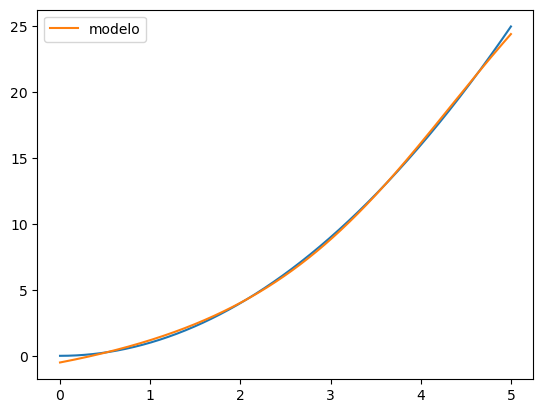

In [26]:
plt.plot(x,y)
plt.plot(x,model.predict(x),label='modelo')
plt.legend()

In [27]:
x = tf.Variable(np.pi)

with tf.GradientTape() as tape:
    y = x**2
    z = tf.sin(2.*y)
print(tape.gradient(z,x))

tf.Tensor(7.9128013, shape=(), dtype=float32)


In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from edo import EDOModel


model = EDOModel(activations='relu',hiddens=2,denses=300)

model.compile(optimizer='adam')
x = tf.linspace(0,5,1000)[:,tf.newaxis]
y = np.exp(x)
model.fit(x,y,epochs=100)

Epoch 1/100
Tensor("gradient_tape/edo_model_2_1/hidden1_1/MatMul/MatMul:0", shape=(None, 1), dtype=float32)
Tensor("gradient_tape/edo_model_2_1/hidden1_1/MatMul/MatMul:0", shape=(None, 1), dtype=float32)
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5489   
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4315
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4163
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3983
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4078 
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4101
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4005 
Epoch 8/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4027 
Epoch 9/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4025
Epoch 10/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3979
Epoch 11/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4037 
Epoch 12/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3974 
Epoch

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


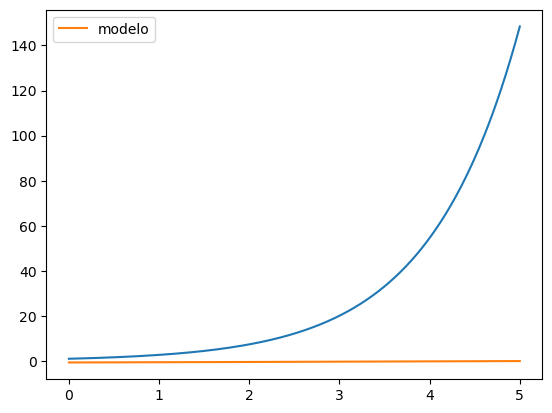

In [10]:
plt.plot(x,y)
plt.plot(x,model.predict(x),label='modelo')
plt.legend()

In [11]:
model.predict(x)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 795us/step


array([[-0.6491917 ],
       [-0.6484976 ],
       [-0.64787483],
       [-0.6472846 ],
       [-0.64675236],
       [-0.6462403 ],
       [-0.64572906],
       [-0.64521784],
       [-0.64470804],
       [-0.6442034 ],
       [-0.64369893],
       [-0.6431944 ],
       [-0.64269596],
       [-0.6421921 ],
       [-0.64166486],
       [-0.64113617],
       [-0.6406079 ],
       [-0.64008003],
       [-0.6395699 ],
       [-0.63906574],
       [-0.63856286],
       [-0.63806003],
       [-0.63755804],
       [-0.6370563 ],
       [-0.6365551 ],
       [-0.6360538 ],
       [-0.6355526 ],
       [-0.6350513 ],
       [-0.63456273],
       [-0.6340765 ],
       [-0.6335885 ],
       [-0.6331005 ],
       [-0.63261276],
       [-0.632125  ],
       [-0.63163733],
       [-0.6311496 ],
       [-0.63066155],
       [-0.6301758 ],
       [-0.6296908 ],
       [-0.6292058 ],
       [-0.62872183],
       [-0.62823766],
       [-0.62774795],
       [-0.6272471 ],
       [-0.6267334 ],
       [-0

In [12]:
y

array([[  1.        ],
       [  1.00501755],
       [  1.01006028],
       [  1.01512831],
       [  1.02022176],
       [  1.02534078],
       [  1.03048548],
       [  1.03565599],
       [  1.04085245],
       [  1.04607498],
       [  1.05132371],
       [  1.05659878],
       [  1.06190032],
       [  1.06722846],
       [  1.07258333],
       [  1.07796508],
       [  1.08337382],
       [  1.0888097 ],
       [  1.09427286],
       [  1.09976343],
       [  1.10528155],
       [  1.11082736],
       [  1.11640099],
       [  1.12200259],
       [  1.12763229],
       [  1.13329025],
       [  1.13897659],
       [  1.14469146],
       [  1.15043501],
       [  1.15620738],
       [  1.16200871],
       [  1.16783914],
       [  1.17369884],
       [  1.17958793],
       [  1.18550657],
       [  1.19145491],
       [  1.1974331 ],
       [  1.20344128],
       [  1.20947961],
       [  1.21554823],
       [  1.22164731],
       [  1.22777699],
       [  1.23393742],
       [  1